Date and time  2022-02-07 11:26:57.859771
 
fileList is:  ../CometImages/CA210609/Collated/4GyB/bmp/4GyB009.bmp
fileName is:  4GyB009.bmp
ImgRaw shape (2048, 2048)
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 2048 of columns 2048 of pixels 4194304 and depth 1
Maximum pixel value  210
Minimum pixel value  4
max and min pixel values for  4GyB009.bmp  is:  210 4


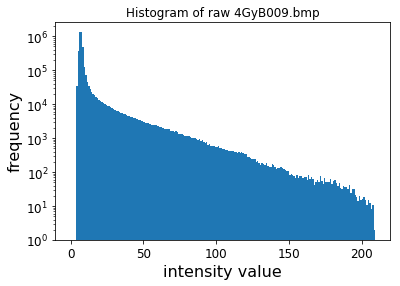

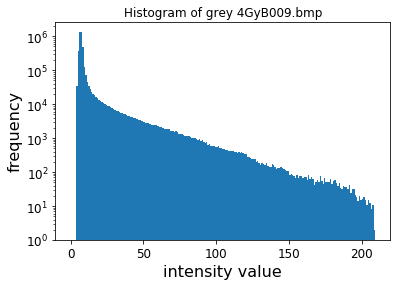

thresh is:  [ 4.2  8.4 12.6 16.8 21. ]
Image dimension in x 2048 pixels, in y 2048 pixels
Clusters analysed if centre in x range 0 to 2048 and y range 0 to 2048


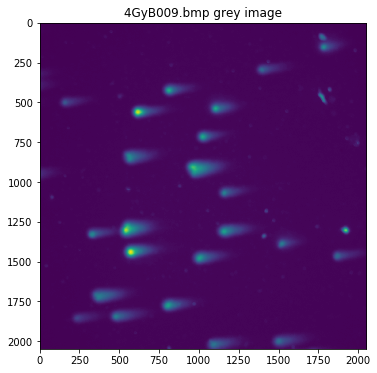

thisThresh is:  12


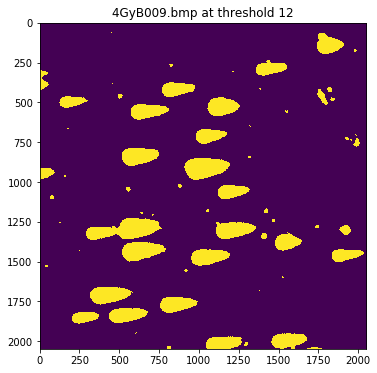

 
Run DBSCAN, threshold number  2  value  12
xIrrad shape:  (416615,)
yIrrad shape:  (416615,)
iThr shape:  (416615,)
imgGrey shape:  (2048, 2048)


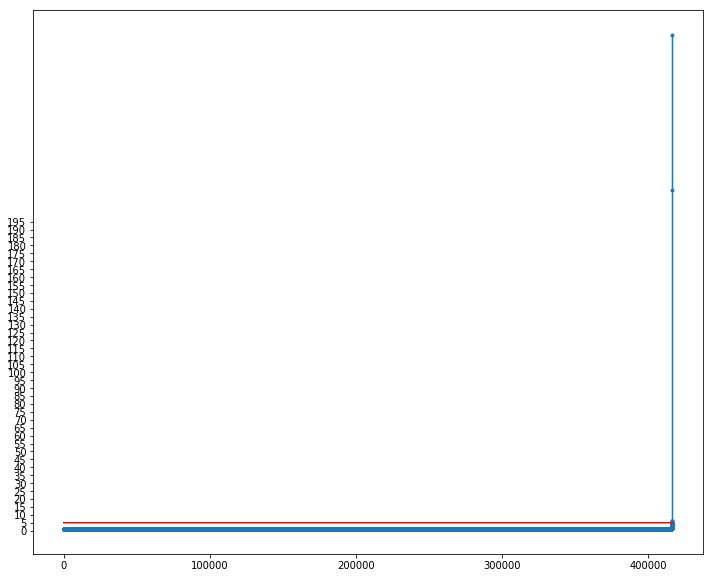

epsilon is:  5


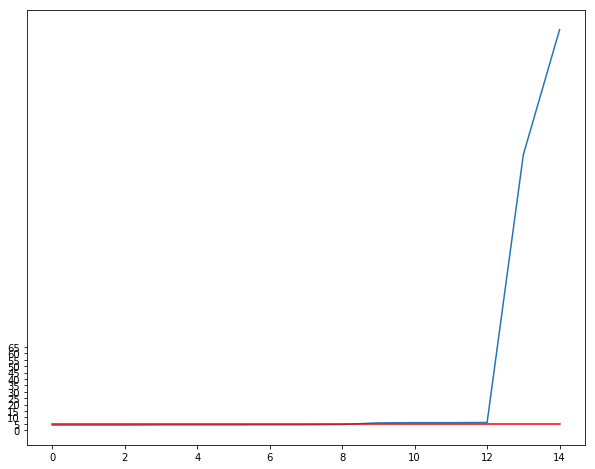

Number of clusters 67
Average number of pixels per cluster 6218.014925373134
Average xWid 94.23880597014926 standard deviation 106.26004283385126
Average yWid 51.26865671641791 standard deviation 43.63846792991495
Number of clusters in fiducial area 67
Average number of pixels per cluster in fiducial area 6218.014925373134
Average xWidFid 23.623256513470192 standard deviation 26.83546857304802
Average yWidFid 12.404053058927145 standard deviation 10.459548178281956


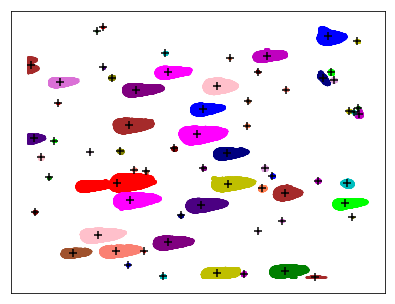

 
Date and time 2022-02-07 11:27:21.626205
Time since last check is 0:00:23.766434


In [5]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
import numpy as np
from sklearn.neighbors import NearestNeighbors
import glob
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
#
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.filters import threshold_local
from sklearn.cluster import DBSCAN
#
withHists = False
minSamples = 4
minPoints = minSamples
#imFile = "../CometImages/CA210609/Collated/4GyA/bmp/4GyA0027.bmp"
#imFile = "../CometImages/exp-val/comets62.bmp"
imFile = "../CometImages/CA210609/Collated/4GyB/bmp/4GyB009.bmp"
#imFile = "../CometImages/CA210819/Collated/4GyBfirst/auto/bmp/4GyBfirstauto4000.bmp"
#imFile = "../CometImages/bulk-set/040517/HeLa59MeV0min/114.bmp"
#imFile = "../CometImages/CA210609/Collated/4GyC/bmp/4GyC0022.bmp"

fileList= sorted(glob.glob(imFile))[0]
print("fileList is: ", fileList)
fileName = [os.path.basename(x) for x in sorted(glob.glob(imFile))][0]
print("fileName is: ", fileName) # reading in filenames from a directory
fileNames = fileName
#
#
imgRaw = plt.imread(fileList)
print("ImgRaw shape",imgRaw.shape)
imgGrey, nRows, nCols = processImage(imgRaw)
nRows = imgRaw.shape[0] #took New out
nCols = imgRaw.shape[1] # ""
if len(imgRaw.shape) == 2:
    nDepth = 1
else:
    nDepth = imgRaw.shape[2] # ""

ImgArr = np.zeros((nRows, nCols))
if nDepth == 1:
    ImgArr[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols] #take out the 3rd dimension (0) if RGB(A) image
else:
    ImgArr[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols, 0]
#
maxPix = np.max(imgGrey)
minPix = np.min(imgGrey)
print("max and min pixel values for ", fileNames, " is: ", maxPix, minPix)
#
#plot histogram of raw image intensities
fig, ax = plt.subplots(1)
plt.title("Histogram of raw " + str(fileNames))
# change font size for x axis
ax.tick_params(axis='both', which='major', labelsize=12)
#
plt.xlabel("intensity value", fontsize = 16)
plt.ylabel("frequency", fontsize = 16)
n, bins, patches = ax.hist(imgRaw.flatten(), bins=np.arange(0, maxPix, 1), log=True)
plt.show()
#plot histogram of grey image intensities
fig, ax = plt.subplots(1)
plt.title("Histogram of grey " + str(fileNames))
# change font size for x axis
ax.tick_params(axis='both', which='major', labelsize=12)
#
plt.xlabel("intensity value", fontsize = 16)
plt.ylabel("frequency", fontsize = 16)
n, bins, patches = ax.hist(imgGrey.flatten(), bins=np.arange(0, maxPix, 1), log=True)
plt.show()
#
thresh = np.linspace(0.02, 0.1, 5) * maxPix
print("thresh is: ", thresh)
nThresh = len(thresh)
#
xEdge = 0   #32
yEdge = 0  #16
xLim = xEdge*np.ones(2).astype(int)
xLim[1] = nCols - xEdge
yLim = yEdge*np.ones(2).astype(int)
yLim[1] = nRows - yEdge
print("Image dimension in x",nCols,"pixels, in y",nRows,"pixels")
print("Clusters analysed if centre in x range",xLim[0],"to",xLim[1],"and y range",yLim[0],"to",yLim[1])
#
#to store cluster info
nMeanPix = np.zeros(nThresh)
xMeanWid = np.zeros(nThresh)
yMeanWid = np.zeros(nThresh)
xStdWid = np.zeros(nThresh)
yStdWid = np.zeros(nThresh)
nClus = np.zeros(nThresh).astype(int)
#
nMeanPixFid = np.zeros(nThresh)
xMeanWidFid = np.zeros(nThresh)
yMeanWidFid = np.zeros(nThresh)
xStdWidFid = np.zeros(nThresh)
yStdWidFid = np.zeros(nThresh)
nClusFid = np.zeros(nThresh).astype(int)
#
nColTab = 20
colorTab = ['r', 'b', 'g', 'y', 'm', 'c', 'Brown', 'Coral', 'Fuchsia', 'Indigo', 'Lime', 'Maroon', \
           'Navy', 'Olive', 'Orchid', 'Pink', 'Plum', 'Purple', 'Salmon', 'Sienna']
#
fig = plt.figure(figsize = (10, 6))
plt.title(str(fileName) + " grey image")
plt.imshow(imgGrey)
plt.show()
#
#for n in range(1, nThresh):
for n in range(2, 3):
    thisThresh = thresh[n].astype(int)
    print("thisThresh is: ", thisThresh)
    imgThr = imgGrey > thisThresh
    fig = plt.figure(figsize = (10, 6))
    plt.title(str(fileName) + " at threshold " + str(thisThresh))
    plt.imshow(imgThr)
    plt.show()
    
    ###########################################
    #from other notebook
    yIrrad, xIrrad = np.where(imgGrey > thisThresh)
    lThresh = len(xIrrad)
    #
    print(" ")
    print("Run DBSCAN, threshold number ",n," value ",thisThresh)
    #
    scanData = np.zeros((lThresh,2))
    scanData[:, 0] = xIrrad
    scanData[:, 1] = yIrrad
    iThr = imgGrey[yIrrad, xIrrad]
    print("xIrrad shape: ", xIrrad.shape)
    print("yIrrad shape: ", yIrrad.shape)
    print("iThr shape: ", iThr.shape)
    print("imgGrey shape: ", imgGrey.shape)
    #
    #Find best epsilon value for minPoints = 4
    epsilon = 5
    neighbors = NearestNeighbors(n_neighbors = minPoints)
    neighbors_fit = neighbors.fit(scanData)
    distances, indices = neighbors_fit.kneighbors(scanData)
    distances = np.sort(distances, axis = 0)
    distances = distances[:,1]
    nDist = len(distances)
    epsLine = np.ones(nDist) * epsilon
    fig = plt.figure(figsize = (12, 10))
    plt.yticks(np.arange(0, 200, 5))
    plt.plot(distances, marker = '.' )
    plt.plot(epsLine, c = 'r' )
    plt.savefig("plots/4GyB009/epsPlot" + str(n) + "-" + str(thisThresh))
    plt.show()
    #
    #zoom in on dist plot to get eps
    print("epsilon is: ", epsilon)
    cropBot = 416600
    cropTop = 416615
    epsLine = np.ones(cropTop-cropBot) * epsilon
    fig = plt.figure(figsize = (10, 8))
    plt.yticks(np.arange(0, 70, 5))
    plt.plot(distances[cropBot:cropTop])
    plt.plot(epsLine, c = 'r')
    plt.show()
    #
    fig = plt.figure(figsize=(6.7, 5.2))
    #plt.title(str(fileName) + " threshold " + str(thisThresh), fontsize = 12)
    #plt.xlabel('x pixel', fontsize = 12)
    #plt.ylabel('y pixel', fontsize = 12)
    #
    if __name__ == '__main__':
        clusterer = DBSCAN(eps = epsilon, min_samples = minSamples).fit(scanData)
    #
    cluster_labels = clusterer.fit_predict(scanData)
    #
    nClusHere = np.amax(cluster_labels) + 1
    #
    nClus[n] = nClusHere
    nPixels = np.zeros(nClusHere)
    nPixelsFid = np.zeros(nClusHere)
    xClusters = np.zeros(nClusHere)
    yClusters = np.zeros(nClusHere)
    xWid = np.zeros(nClusHere)
    yWid = np.zeros(nClusHere)
    xWidFid = np.zeros(nClusHere)
    yWidFid = np.zeros(nClusHere)
    #
    indexCl = np.zeros(lThresh)
    xPixelsCl = np.zeros(lThresh)
    yPixelsCl = np.zeros(lThresh)
    xPixelsHere = np.zeros(lThresh)
    yPixelsHere = np.zeros(lThresh)
    iPixelsHere = np.zeros(lThresh)
    #
    nCol = 0
    nClusFidHere = 0
    for nC in range(0, nClusHere):
        logicalCl = cluster_labels == nC
        nHere = np.sum(logicalCl).astype(int)
        nPixels[nC] = nHere
#
        xPixelsHere = scanData[logicalCl, 0]
        yPixelsHere = scanData[logicalCl, 1]
        iPixelsHere = iThr[logicalCl]
        #
        xClusters[nC] = np.sum(xPixelsHere*iPixelsHere)/np.sum(iPixelsHere)
        yClusters[nC] = np.sum(yPixelsHere*iPixelsHere)/np.sum(iPixelsHere)
        #
        if xClusters[nC] > xLim[0] and xClusters[nC] < xLim[1] and \
            yClusters[nC] > yLim[0] and yClusters[nC] < yLim[1]:
            plt.scatter(xPixelsHere, yPixelsHere, s = 1, c = colorTab[nCol], marker = 'o')
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
            #
            nPixelsFid[nClusFidHere] = nHere
#            xWidFid[nClusFidHere] = np.max(xPixelsHere) - np.min(xPixelsHere)
#            yWidFid[nClusFidHere] = np.max(yPixelsHere) - np.min(yPixelsHere)
            xWidFid[nClusFidHere] = np.std(xPixelsHere)
            yWidFid[nClusFidHere] = np.std(yPixelsHere)
            nClusFidHere = nClusFidHere + 1            
        else:
            plt.scatter(xPixelsHere, yPixelsHere, s = 1, c = "Grey", marker = 'o')
        #
        xWid[nC] = np.max(xPixelsHere) - np.min(xPixelsHere)
        yWid[nC] = np.max(yPixelsHere) - np.min(yPixelsHere)
#        xWid[nC] = np.std(xPixelsHere)
#        yWid[nC] = np.std(yPixelsHere)
        #
    nClusFid[n] = nClusFidHere
    #
    # Add cluster positions to plot for this region
    nMeanPix[n] = np.mean(np.trim_zeros(nPixels, 'b'))
    xMeanWid[n] = np.mean(xWid)
    yMeanWid[n] = np.mean(yWid)
    xStdWid[n] = np.std(xWid)
    yStdWid[n] = np.std(yWid)
    #
    nMeanPixFid[n] = np.mean(np.trim_zeros(nPixelsFid, 'b'))
    xMeanWidFid[n] = np.mean(xWidFid)
    yMeanWidFid[n] = np.mean(yWidFid)
    xStdWidFid[n] = np.std(xWidFid)
    yStdWidFid[n] = np.std(yWidFid)
    print("Number of clusters",nClus[n])
    print("Average number of pixels per cluster",nMeanPix[n])
    print("Average xWid",xMeanWid[n],"standard deviation",xStdWid[n])
    print("Average yWid",yMeanWid[n],"standard deviation",yStdWid[n])
    print("Number of clusters in fiducial area",nClusFid[n])
    print("Average number of pixels per cluster in fiducial area",nMeanPixFid[n])
    print("Average xWidFid",xMeanWidFid[n],"standard deviation",xStdWidFid[n])
    print("Average yWidFid",yMeanWidFid[n],"standard deviation",yStdWidFid[n])
    plt.scatter(xClusters, yClusters, s = 50, c = 'k', marker = '+')
    #
    #plt.xlim(-0.05*nCols, 1.05*nCols)
    #plt.ylim(-0.05*nRows, 1.05*nRows)
    plt.gca().invert_yaxis()
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    #plt.axis('off')
    #plt.savefig("plots/4GyB009/DBSCANthr" + str(n) + "-" + str(thisThresh))
    plt.show()
    ###################################
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then)) 

## routines for processing image

In [2]:
def processImage(imgRaw):
    #
    import sys
    import numpy as np
    import scipy.ndimage as scimg
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    nRows = imgRaw.shape[0] 
    nCols = imgRaw.shape[1]
    if len(imgRaw.shape) == 3:
        nDepth = imgRaw.shape[2]
    else:
        nDepth = 1
    #
    thresh = [30, 180]
    nThresh = len(thresh)
    img = np.zeros((nRows, nCols))
    imgThr = np.zeros((nRows, nCols, nThresh))
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    """
    # Remove "hot" pixels
    print(" ")
    print("Maximum pixel value before removing hot pixels",np.amax(imgGrey))
    print("Minimum pixel value ",np.amin(imgGrey))
    hotPixels = imgGrey > hotCut
    imgGrey[hotPixels] = 0
    #
    # Rescale 
    #imgGrey = np.asarray(255//hotCut*imgGrey, dtype = np.uint8)
    imgGrey = np.asarray((255/hotCut)*imgGrey, dtype = np.uint8)
    """
    #
    print("Type of raw image file is",imgRaw.dtype)
    print("Type of greyscale image file is",imgGrey.dtype)
    print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
    #print("Hot pixel cut",hotCut)
    #print("Number of hot pixels",np.sum(hotPixels))
    #print("Maximum pixel value after removing hot pixels",np.amax(imgGrey))
    print("Maximum pixel value ", np.amax(imgGrey))
    print("Minimum pixel value ",np.amin(imgGrey))
    #
    return imgGrey, nRows, nCols

def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0, withHists = False):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    if withHists:
        print(" ")
        print("Max intensities red",np.amax(r),"green",np.amax(g), "blue",np.amax(b))
        print(" ")
        nBins = int(256/8)
        nBins = 256
        plt.figure(figsize = (12, 9))
        plt.subplot(4, 1, 1)
        plt.hist(np.ravel(r), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(np.ravel(g), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 3)
        plt.hist(np.ravel(b), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 4)
        plt.hist(np.ravel(grey), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.tight_layout()
        plt.show()
    #
    return np.asarray(grey, dtype = np.uint8)
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
############################################
def rgbSeperate(rgb, filename, withPlots = False):
    '''
    Seperate RGB image into the R, G, B components and plot image in each of these individual channels.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    #grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    if withPlots == True:
        plt.figure(figsize = (12, 9))
        plt.subplot(2, 2, 1)
        plt.title("raw image" + str(filename))
        plt.imshow(rgb, cmap='afmhot')
        plt.subplot(2, 2, 2)
        plt.title("red channel")
        plt.imshow(r, cmap='afmhot')
        plt.subplot(2, 2, 3)
        plt.title("green channel")
        plt.imshow(g, cmap='afmhot')
        plt.subplot(2, 2, 4)
        plt.title("blue channel")
        plt.imshow(b, cmap='afmhot')
        plt.show()
    
    return r, g, b


import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
def edgeFinderIn(picture, edgeWidth, useDiag = True):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    The edges are inside the original image. The flag useDiag ensures "corner" pixels are selected.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    # Right edge
    imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgShift[0:nRows, nCols - shiftC:nCols] = False
    edges = np.logical_and(picture, np.logical_not(imgShift))
    #
    # Left edge 
    imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgShift[0:nRows, 0:shiftC] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Lower edge 
    imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgShift[0:shiftR, 0:nCols] = False    
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Upper edge 
    imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
    imgShift[nRows - shiftR:nRows, 0:nCols] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    if useDiag:
        #
        # Left upper edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Left lower edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right upper edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right lower edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    return edges
#
#
def expander(picture, edgeWidth, useDiag = True):
    '''
    Return array containing thresholded regions expanded by band of width edgeWidth. The flag useDiag ensures
    "corner" pixels are included correctly.
    '''
    #
    shiftR = 1
    shiftC = 1
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    edgeSum = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    for  nE in range(0, edgeWidth):
        #
        # Left edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        edges = np.logical_and(np.logical_not(picture), imgShift)
        #
        # Right edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Upper edge 
        imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Lower edge 
        imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        if useDiag:
            #
            # Left upper edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Left lower edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right upper edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right lower edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        picture = np.logical_or(picture, edges)
        edgeSum = np.logical_or(edges, edgeSum)
    #
    return picture, edgeSum
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2022-02-07 11:25:10.316839
 
Date and time 2022-02-07 11:25:10.317941
Time since last check is 0:00:00.001102
